In [1]:
# load in the necessary packages

from goes2go import GOES
import pandas as pd
from datetime import datetime
import xarray as xr
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import os

i am going to load in the GOES data first

In [2]:
# load in the datasets

import xarray as xr

# Directory containing NetCDF files
data_dir = "/glade/work/adhall/Data/GOES_DATA/ProcessGOESData/RemappedNetCDF/"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".nc")]

# Load all NetCDF files into a single xarray Dataset
combined_dataset_goes = xr.open_mfdataset(
    files,
    combine='by_coords'  # Aligns by coordinates (time, lat, lon)
)


/glade/u/home/adhall/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Could not load the ecCodes library!
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
combined_dataset_goes

<xarray.Dataset> Size: 5MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables:
    CloudImagery         (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    CloudTopTemperature  (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    DownwardSW           (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    ReflectedSW          (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    TotalPrecipWater     (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

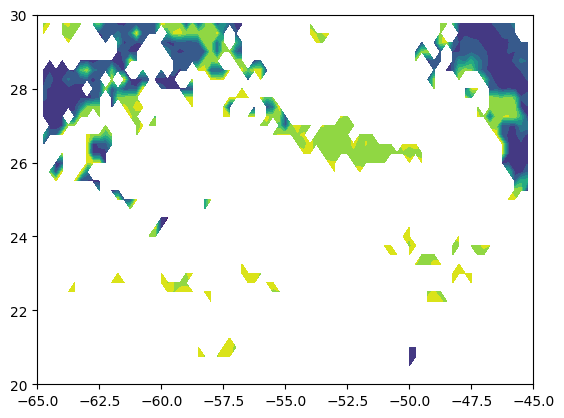

In [4]:
plt.contourf(combined_dataset_goes.longitude.values, combined_dataset_goes.latitude.values, combined_dataset_goes.CloudTopTemperature[0,:,:].values)

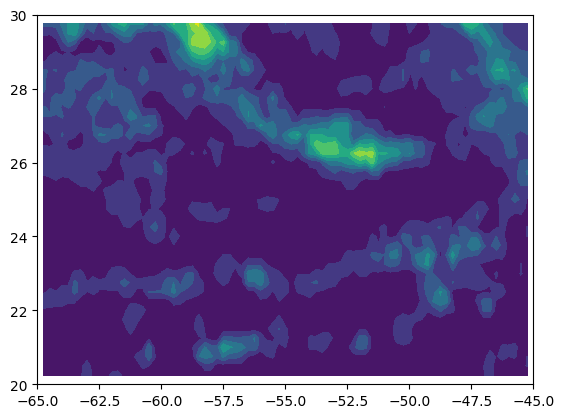

In [5]:
plt.contourf(combined_dataset_goes.longitude.values, combined_dataset_goes.latitude.values, combined_dataset_goes.ReflectedSW[0,:,:].values)

slay what a success

now era5 data

In [6]:
# get the era5 data as well

dir = "/glade/derecho/scratch/adhall/"

# Load your dataset
ds_era5 = xr.open_dataset(dir + "era5_single_levels.nc")

# 1. Subset the dataset for April 2020
ds_era5_april_2020 = ds_era5.sel(
    valid_time=(ds_era5['valid_time.year'] == 2020) & (ds_era5['valid_time.month'] == 4)
)

# 2. Subset for the time 15:00 UTC
ds_era5_april_2020_1500 = ds_era5_april_2020.sel(
    valid_time=ds_era5_april_2020['valid_time'].dt.hour == 15
)


another success! so far so good

i need to convert the times for era5 to julian days 92-121 now

In [7]:
# Create the Julian days for April 2020 (92 to 121)
date_range = pd.date_range("2020-04-01", "2020-04-30", freq="D")
julian_days = [date.dayofyear for date in date_range]  # Getting Julian days 92 to 121

# Create a new 'time' variable with Julian days
ds_era5_april_2020_1500.coords['time'] = ('valid_time', julian_days)

# Now, we can drop the 'valid_time' dimension and rename the new 'time' dimension
ds_era5_april_2020_1500 = ds_era5_april_2020_1500.drop('valid_time')

# Now, all variables will have 'time', 'lat', and 'lon' dimensions
ds_era5_april_2020_1500 = ds_era5_april_2020_1500.rename({'valid_time': 'time'})

/glade/derecho/scratch/adhall/tmp/ipykernel_27505/3298746871.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_era5_april_2020_1500 = ds_era5_april_2020_1500.drop('valid_time')
/glade/derecho/scratch/adhall/tmp/ipykernel_27505/3298746871.py:12: UserWarning: rename 'valid_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds_era5_april_2020_1500 = ds_era5_april_2020_1500.rename({'valid_time': 'time'})


In [8]:
ds_era5_april_2020_1500

<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 41, longitude: 81, time: 30)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 328B 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
    expver     (time) <U4 480B ...
    time       (time) int64 240B 92 93 94 95 96 97 ... 116 117 118 119 120 121
Data variables:
    u10        (time, latitude, longitude) float32 399kB ...
    v10        (time, latitude, longitude) float32 399kB ...
    t2m        (time, latitude, longitude) float32 399kB ...
    sst        (time, latitude, longitude) float32 399kB ...
    slhf       (time, latitude, longitude) float32 399kB ...
    sshf       (time, latitude, longitude) float32 399kB ...
    hcc        (time, latitude, longitude) float32 399kB ...
    lcc        (time, latitude, longitude) float32 399kB ...
    tcc        (time, latitude, longitude) float32 399kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-20T20:22 GRIB to CDM+CF via cfgrib-0.9.1...

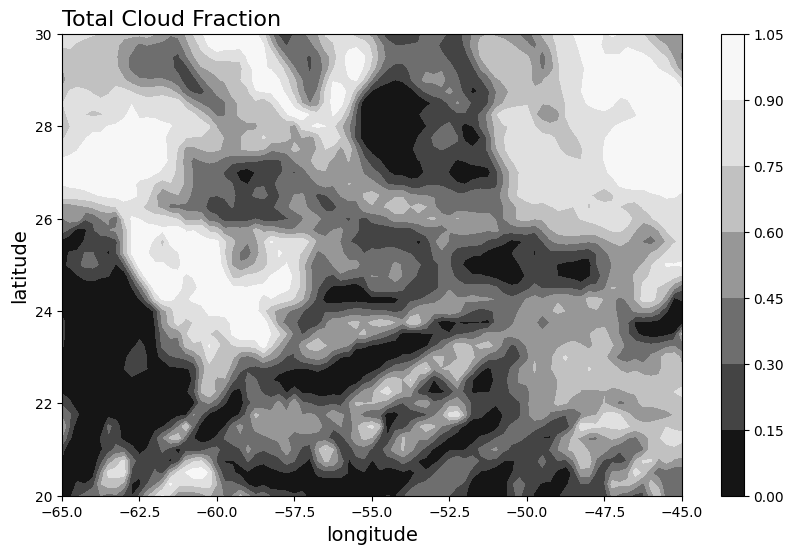

In [9]:
# plot the tcc
plt.figure(figsize=(10, 6))
plt.contourf(ds_era5_april_2020_1500.longitude.values, ds_era5_april_2020_1500.latitude.values, ds_era5_april_2020_1500.tcc[0,:,:].values, cmap='Greys_r')
plt.title("Total Cloud Fraction", loc='left', fontsize=16)
plt.ylabel("latitude", fontsize=14)
plt.xlabel("longitude", fontsize=14)
plt.colorbar()

In [10]:
# Apply the thresholding operation to create binary values
ds_era5_april_2020_1500['tcc'] = (ds_era5_april_2020_1500['tcc'] >= 0.5).astype("int8")  # Use "int8" for compact integer storage

print("Binary conversion applied. The dataset has been updated.")

Binary conversion applied. The dataset has been updated.


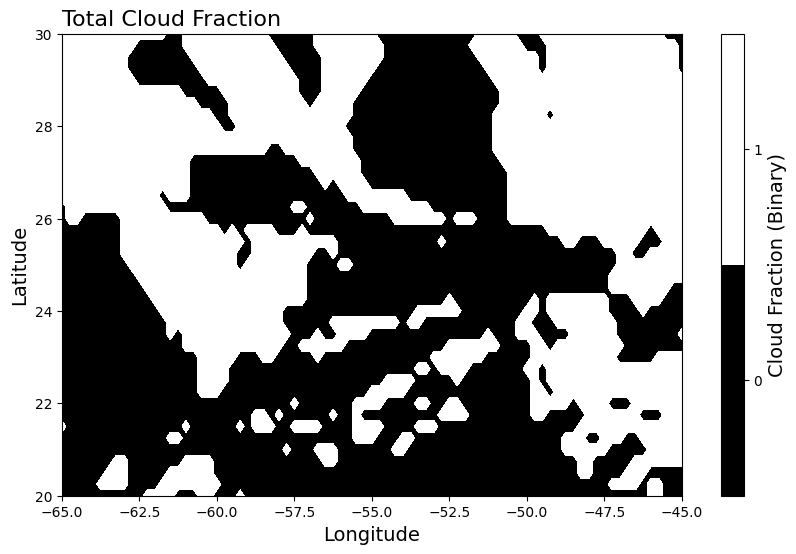

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define a binary colormap (black for 0, white for 1)
binary_cmap = mcolors.ListedColormap(['black', 'white'])

# Plot the binary 'tcc' field
plt.figure(figsize=(10, 6))
plt.contourf(
    ds_era5_april_2020_1500.longitude.values, 
    ds_era5_april_2020_1500.latitude.values, 
    ds_era5_april_2020_1500.tcc[0, :, :].values, 
    levels=[-0.5, 0.5, 1.5],  # Define levels to ensure binary separation
    cmap=binary_cmap
)

# Add title and labels
plt.title("Total Cloud Fraction", loc='left', fontsize=16)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# Add a discrete colorbar
colorbar = plt.colorbar(ticks=[0, 1])  # Colorbar with ticks for 0 and 1
colorbar.set_label("Cloud Fraction (Binary)", fontsize=14)

plt.show()


another success

now we have to fill in the missing data in the goes dataset with bilinear interpolation

In [12]:
import numpy as np
from scipy.interpolate import griddata

def fill_nans_with_interpolation(ds):
    """
    Fill NaN values in the dataset using bilinear interpolation and nearest-neighbor fallback.
    """
    lat = ds.latitude.values
    lon = ds.longitude.values
    lon_flat, lat_flat = np.meshgrid(lon, lat)
    lon_flat = lon_flat.flatten()
    lat_flat = lat_flat.flatten()
    points = np.column_stack((lat_flat, lon_flat))

    for var_name in ds.data_vars:
        data = ds[var_name].values
        for time_index in range(data.shape[0]):  # Assuming time is the first dimension
            data_slice = data[time_index, :, :]
            mask = ~np.isnan(data_slice)
            valid_points = points[mask.flatten()]
            valid_values = data_slice[mask]

            # Bilinear interpolation for initial pass
            interpolated_data = griddata(valid_points, valid_values, points, method='linear')

            # Replace NaNs with bilinear interpolation
            data[time_index, :, :] = interpolated_data.reshape(data_slice.shape)

            # Fallback for remaining NaNs using nearest-neighbor interpolation
            if np.isnan(data_slice).any():
                fallback_data = griddata(valid_points, valid_values, points, method='nearest')
                fallback_data = fallback_data.reshape(data_slice.shape)
                data[time_index, :, :] = np.where(np.isnan(data[time_index, :, :]), fallback_data, data[time_index, :, :])
        
        # Update the dataset
        ds[var_name].values = data

    return ds

# Apply the function to your dataset
combined_dataset_goes_filled = fill_nans_with_interpolation(combined_dataset_goes)


In [13]:
combined_dataset_goes_filled

<xarray.Dataset> Size: 5MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables:
    CloudImagery         (time, latitude, longitude) float64 797kB 0.2423 ......
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

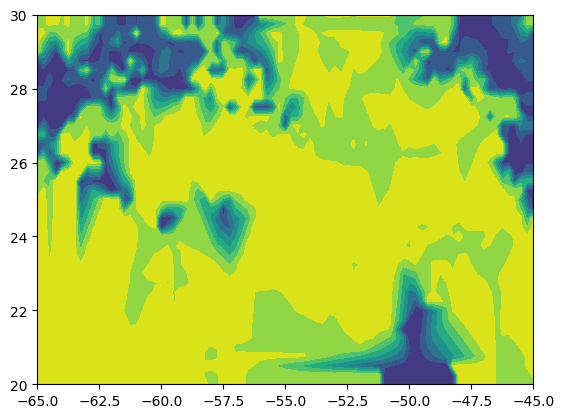

In [14]:
plt.contourf(combined_dataset_goes_filled.longitude.values, combined_dataset_goes_filled.latitude.values, combined_dataset_goes_filled.CloudTopTemperature[0,:,:].values)

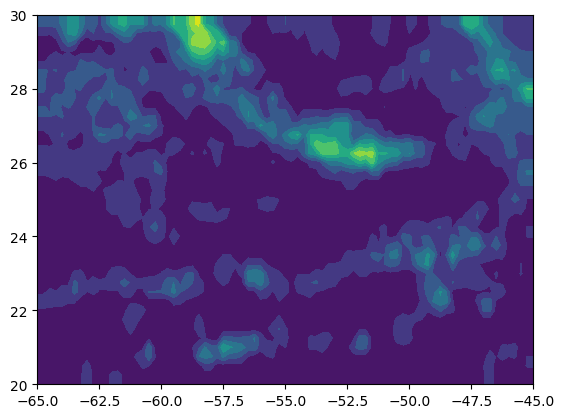

In [15]:
plt.contourf(combined_dataset_goes_filled.longitude.values, combined_dataset_goes_filled.latitude.values, combined_dataset_goes_filled.ReflectedSW[0,:,:].values)

it apppears to have worked

there is some missing edges for temperature, not sure what this is about but such is life

now we combine the two datasets

In [16]:
combined_dataset = xr.merge([combined_dataset_goes_filled, ds_era5_april_2020_1500])

In [17]:
combined_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
    number               int64 8B ...
    expver               (time) <U4 480B ...
Data variables: (12/15)
    CloudImagery         (time, latitude, longitude) float64 797kB 0.2423 ......
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB ...
    slhf                 (time, latitude, longitude) float32 399kB ...
    sshf                 (time, latitude, longitude) float32 399kB ...
    hcc                  (time, latitude, longitude) float32 399kB ...
    lcc                  (time, latitude, longitude) float32 399kB ...
    tcc                  (time, latitude, longitude) int8 100kB 0 0 0 ... 1 1 1
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

need to delete number and expver asap rocky

In [18]:
# Specify the names of the extra coordinates to be removed
extra_coords = ['number', 'expver']  # Replace with the actual coordinate names

# Drop the unwanted coordinates
cleaned_dataset = combined_dataset.drop_vars(extra_coords)

In [19]:
# List of predictor variables
variables = [
    'CloudImagery',
    'ReflectedSW',
    'CloudTopTemperature',
    'CloudOpticalDepth',
    't2m',
    'sst',
    'lcc',
    'hcc',
    'u10',
    'v10',
    'sshf',
    'slhf',
    'tcc',
]


# Select predictors from the xarray dataset
variables = cleaned_dataset[variables].to_array().values  # Converts to NumPy array

In [20]:
import numpy as np

# Check predictors and targets
print(f"NaN in predictors: {np.isnan(variables).any()}")
print(f"Inf in predictors: {np.isinf(variables).any()}")


NaN in predictors: False
Inf in predictors: False


In [21]:
cleaned_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables: (12/15)
    CloudImagery         (time, latitude, longitude) float64 797kB 0.2423 ......
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB 299.4 ... ...
    slhf                 (time, latitude, longitude) float32 399kB -5.819e+05...
    sshf                 (time, latitude, longitude) float32 399kB -3.21e+04 ...
    hcc                  (time, latitude, longitude) float32 399kB 0.0 ... 0....
    lcc                  (time, latitude, longitude) float32 399kB 0.1067 ......
    tcc                  (time, latitude, longitude) int8 100kB 0 0 0 ... 1 1 1
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

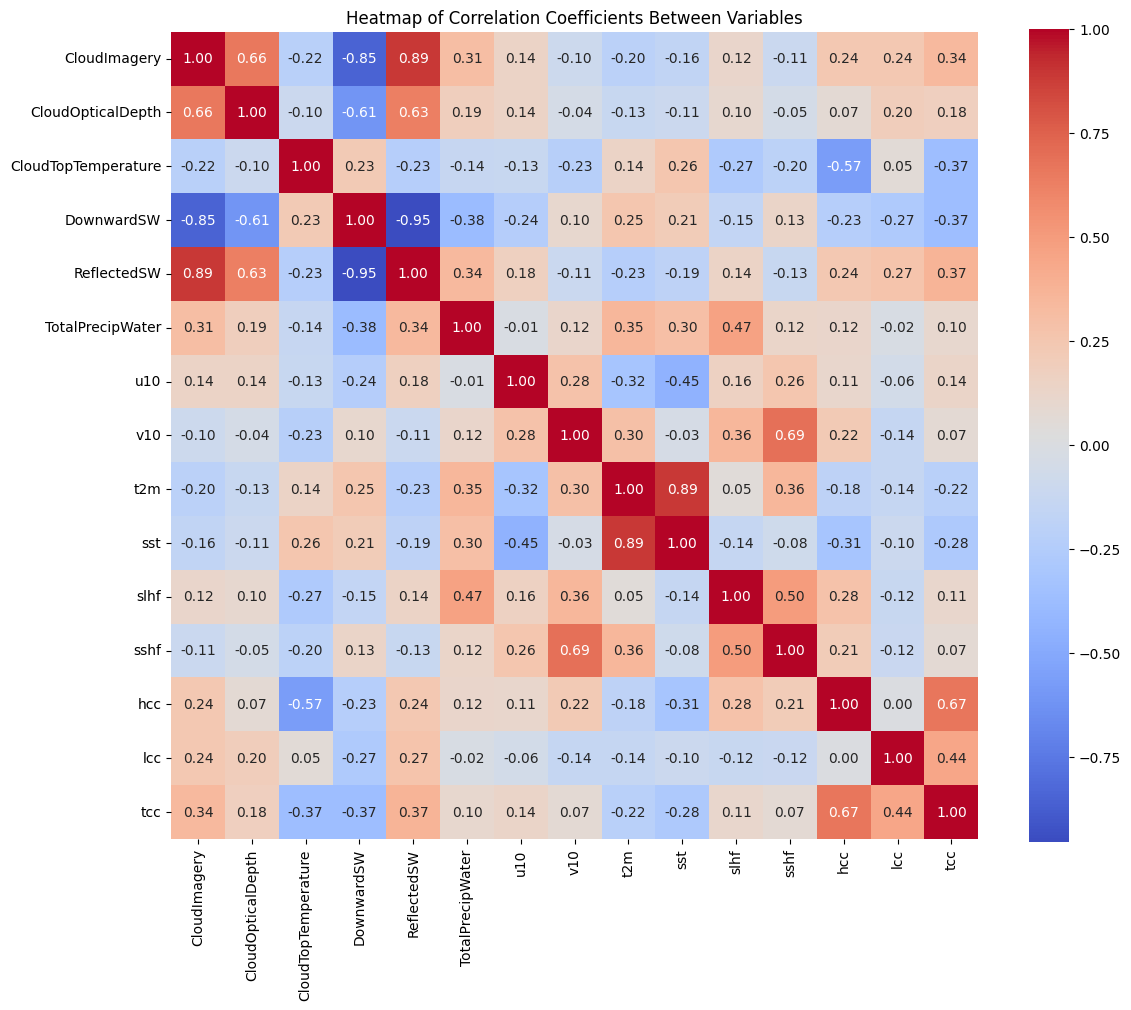

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_dataset is your xarray.Dataset
# Convert the dataset to a Pandas DataFrame and drop missing values
df = cleaned_dataset.to_dataframe().dropna()

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,        # Show correlation coefficients
    fmt=".2f",         # Format coefficients with 2 decimal points
    cmap="coolwarm",   # Color map for heatmap
    cbar=True,         # Show color bar
    square=True        # Make cells square
)
plt.title("Heatmap of Correlation Coefficients Between Variables")
plt.tight_layout()
plt.show()


now we need to print out the highly correlated pairs because i am lazy

In [23]:
cleaned_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables: (12/15)
    CloudImagery         (time, latitude, longitude) float64 797kB 0.2423 ......
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB 299.4 ... ...
    slhf                 (time, latitude, longitude) float32 399kB -5.819e+05...
    sshf                 (time, latitude, longitude) float32 399kB -3.21e+04 ...
    hcc                  (time, latitude, longitude) float32 399kB 0.0 ... 0....
    lcc                  (time, latitude, longitude) float32 399kB 0.1067 ......
    tcc                  (time, latitude, longitude) int8 100kB 0 0 0 ... 1 1 1
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

In [27]:
# get the values from each of the three main variables in each loaded dataset

COD = cleaned_dataset['CloudOpticalDepth'].values 
CID = cleaned_dataset['CloudImagery'].values
RSW = cleaned_dataset['ReflectedSW'].values
CTT = cleaned_dataset['CloudTopTemperature'].values
DSW = cleaned_dataset['DownwardSW'].values
TPW = cleaned_dataset['TotalPrecipWater'].values

u10 = cleaned_dataset['u10'].values 
v10 = cleaned_dataset['v10'].values
t2m = cleaned_dataset['t2m'].values
sst = cleaned_dataset['sst'].values
slhf = cleaned_dataset['slhf'].values
sshf = cleaned_dataset['sshf'].values
tcc = cleaned_dataset['tcc'].values

In [28]:
# flatten the arrays to manageable 1 dimensional arrays

COD = COD.flatten()
CID = CID.flatten()
RSW = RSW.flatten()
CTT = CTT.flatten()
DSW = DSW.flatten()
TPW = TPW.flatten()
u10 = u10.flatten()
v10 = v10.flatten()
t2m = t2m.flatten()
sst = sst.flatten()
slhf = slhf.flatten()
sshf = sshf.flatten()
tcc = tcc.flatten()

In [29]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# basic tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

# classifiers from sklearns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [35]:
# preparing the data for cluster analysis, we will also attempt a time series analysis (one should keep in mind that we onlyhave 10 days)

times = cleaned_dataset.time.values
time3, lat_remapped3, lon_remapped3 = np.meshgrid(cleaned_dataset.time.values,cleaned_dataset.latitude.values,cleaned_dataset.longitude.values,indexing='ij')
df = pd.DataFrame({'time':time3.flatten(),'lon':lon_remapped3.flatten(),'lat':lat_remapped3.flatten(),"COD":COD, "CID":CID, "RSW":RSW, "CTT":CTT, "DSW":DSW, "TPW":TPW, "u10":u10, "v10":v10, "t2m":t2m, "sst":sst, "slhf":slhf, "sshf":sshf, "tcc":tcc})

df.dropna(inplace=True)
df = df.loc[~((df.COD==0))]

data = df[["COD", "CID", "RSW", "CTT", "DSW", "TPW", "u10", "v10", "t2m", "sst", "slhf", "sshf", "tcc"]].values

df0 = df.loc[df.time==times[0]]
data0 = df0[["COD", "CID", "RSW", "CTT", "DSW", "TPW", "u10", "v10", "t2m", "sst", "slhf", "sshf", "tcc"]].values

correlation_matrix = df0[["COD", "CID", "RSW", "CTT", "DSW", "TPW", "u10", "v10", "t2m", "sst", "slhf", "sshf", "tcc"]].corr() # correlation matrix at time 0
correlation_matrix.style.background_gradient()

,COD,CID,RSW,CTT,DSW,TPW,u10,v10,t2m,sst,slhf,sshf,tcc
COD,1.000000,0.500159,0.396633,0.161619,-0.320041,0.108737,-0.019064,-0.110673,0.000003,0.002263,0.141535,-0.002917,0.032787
CID,0.500159,1.000000,0.755567,-0.198038,-0.694010,0.243318,0.301867,-0.096905,-0.339534,-0.380228,0.029550,0.056266,0.245501
RSW,0.396633,0.755567,1.000000,-0.266800,-0.900112,0.242112,0.260234,-0.046281,-0.353000,-0.399876,0.097771,0.099131,0.260033
CTT,0.161619,-0.198038,-0.266800,1.000000,0.315383,0.002597,-0.257831,-0.091209,0.317954,0.370690,0.087047,-0.135109,-0.266970
DSW,-0.320041,-0.694010,-0.900112,0.315383,1.000000,-0.098051,-0.285196,-0.099106,0.467455,0.519696,-0.004888,-0.091616,-0.302565
TPW,0.108737,0.243318,0.242112,0.002597,-0.098051,1.000000,0.503272,-0.495142,-0.160711,-0.280214,0.319919,0.271184,0.136300
u10,-0.019064,0.301867,0.260234,-0.257831,-0.285196,0.503272,1.000000,-0.331589,-0.637185,-0.779638,-0.308881,0.095165,0.384933
v10,-0.110673,-0.096905,-0.046281,-0.091209,-0.099106,-0.495142,-0.331589,1.000000,0.471430,0.337932,-0.325828,0.410554,0.081554
t2m,0.000003,-0.339534,-0.353000,0.317954,0.467455,-0.160711,-0.637185,0.471430,1.000000,0.933297,0.057458,0.334629,-0.249791
sst,0.002263,-0.380228,-0.399876,0.370690,0.519696,-0.280214,-0.779638,0.337932,0.933297,1.000000,0.078336,0.008148,-0.338594


In [36]:
# This is to predict cloud optical depth from reflected shortwave and cloud imagery

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target variable
y = df0['tcc']  # Cloud fraction as the target
X = df0.drop(columns=['tcc'])  # Remaining features as predictors

# Define the regression model
clf = LinearRegression()

# Normalize features
X = StandardScaler().fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Calculate the mean accuracy (R^2 score) on the test set
score = clf.score(X_test, y_test)
print("The R^2 score on the test data is %f" % score)


The R^2 score on the test data is 0.234020


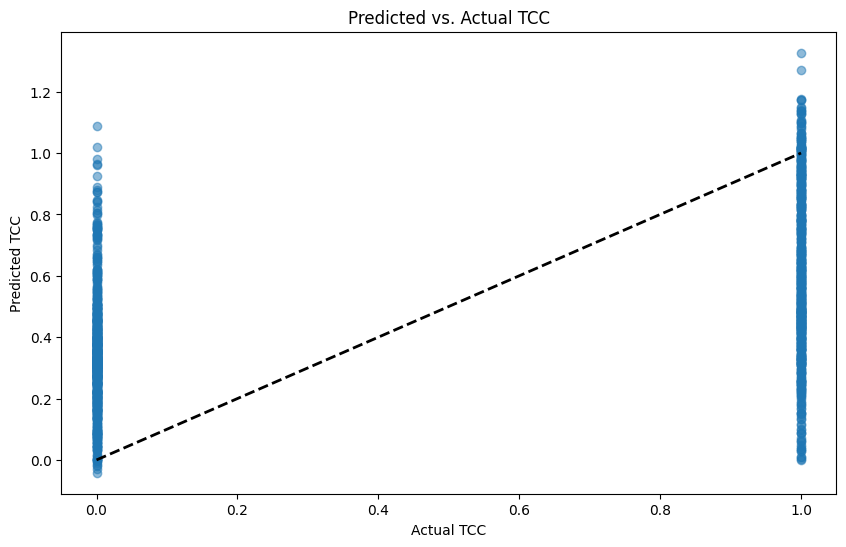

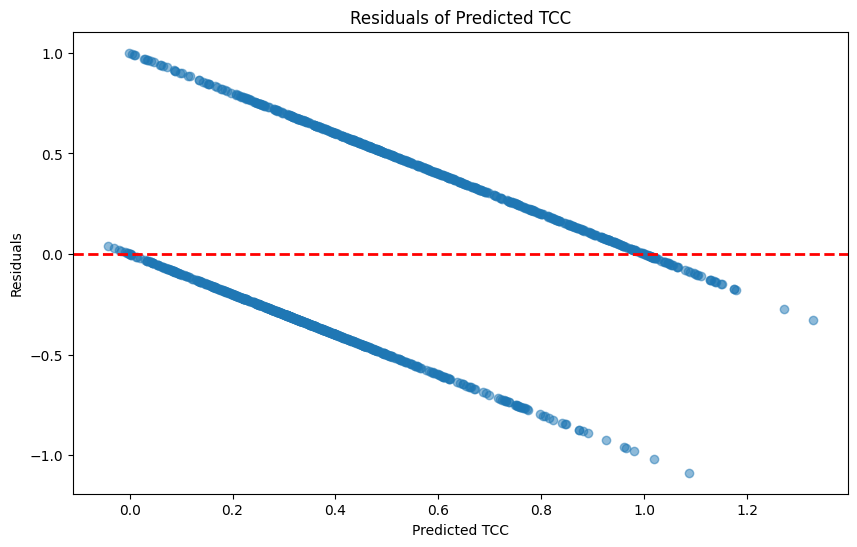

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict COD values for the test set
y_pred = clf.predict(X_test)

# Plot 1: Predicted vs. Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual TCC')
plt.ylabel('Predicted TCC')
plt.title('Predicted vs. Actual TCC')
plt.show()

# Plot 2: Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted TCC')
plt.ylabel('Residuals')
plt.title('Residuals of Predicted TCC')
plt.show()


In [38]:
from pycaret.regression import *

s_regress = setup(df0, target='tcc', session_id=123)



,Description,Value
0,Session id,123
1,Target,tcc
2,Target type,Regression
3,Original data shape,"(3321, 16)"
4,Transformed data shape,"(3321, 16)"
5,Transformed train set shape,"(2324, 16)"
6,Transformed test set shape,"(997, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [39]:
best_regress = compare_models(include=[
    'lr',       # Linear Regression
    'lasso',    # Lasso Regression
    'ridge',    # Ridge Regression
    'en',       # Elastic Net
    'lar',      # Least Angle Regression
    'llar',     # Lasso Least Angle Regression
    'omp',      # Orthogonal Matching Pursuit
    'br',       # Bayesian Ridge
    'ard',      # Automatic Relevance Determination
    'par',      # Passive Aggressive Regressor
    'ransac',   # RANSAC Regressor
    'tr',       # TheilSen Regressor
    'huber',    # Huber Regressor
    # 'kr',       # Kernel Ridge
    'svm',      # Support Vector Machine
    'knn',      # K-Nearest Neighbors
    'dt',       # Decision Tree
    'ada',      # AdaBoost Regressor
    'gbr',      # Gradient Boosting Regressor
    'mlp',      # Multi-layer Perceptron
    'lightgbm', # LightGBM
], fold=3)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2147,0.1008,0.3175,0.5950,0.2222,0.2316,0.1233
gbr,Gradient Boosting Regressor,0.2629,0.1219,0.3490,0.5102,0.2449,0.2861,0.6467
ada,AdaBoost Regressor,0.3892,0.1751,0.4184,0.2966,0.2979,0.3988,0.1100
dt,Decision Tree Regressor,0.1863,0.1863,0.4314,0.2515,0.2991,0.2075,0.0367
ridge,Ridge Regression,0.3759,0.1876,0.4331,0.2464,0.3045,0.4068,0.0133
lr,Linear Regression,0.3759,0.1877,0.4332,0.2461,0.3045,0.4070,0.0233
lar,Least Angle Regression,0.3755,0.1886,0.4343,0.2422,0.3052,0.4081,0.0267
br,Bayesian Ridge,0.3802,0.1893,0.4350,0.2397,0.3061,0.4087,0.0200
en,Elastic Net,0.4140,0.2036,0.4512,0.1822,0.3164,0.4456,0.0133
tr,TheilSen Regressor,0.3754,0.2042,0.4518,0.1796,0.3080,0.4407,0.6167


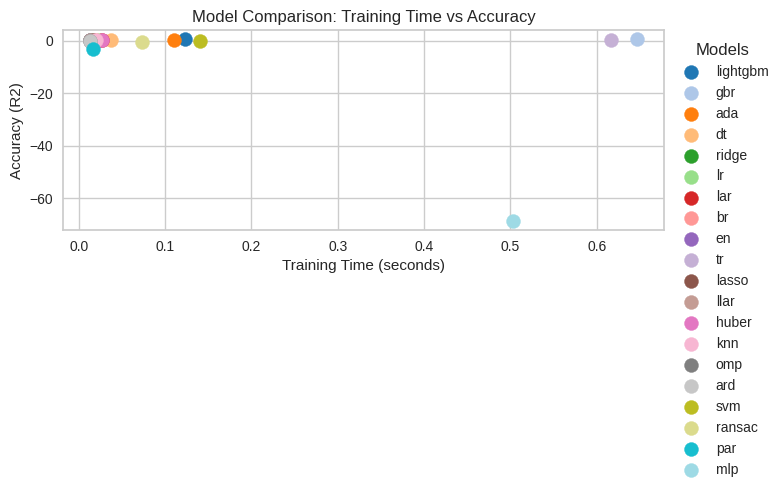

In [40]:
from pycaret.regression import compare_models, pull
import matplotlib.pyplot as plt


results_df = pull() 

tt = results_df['TT (Sec)']          
accuracy = results_df['R2']     
model_names = results_df.index   

plt.figure(figsize=(8, 4))

colors = plt.cm.tab20(range(len(model_names))) 

for i, model in enumerate(model_names):
    plt.scatter(tt[i], accuracy[i], color=colors[i], label=model, s=100)

# Customize plot
plt.title('Model Comparison: Training Time vs Accuracy')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy (R2)')
plt.grid(True)

# Adding legend
plt.legend(title="Models", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()  
plt.show()


In [41]:
tuned_model = tune_model(best_regress) # set up own models in sci kit learn for better analysis.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2230,0.0966,0.3108,0.6098,0.2149,0.2669
1,0.2328,0.1153,0.3396,0.5382,0.2362,0.2595
2,0.2277,0.1134,0.3368,0.5410,0.2358,0.2680
3,0.2061,0.0920,0.3033,0.6317,0.2161,0.1961
4,0.2222,0.1064,0.3262,0.5649,0.2329,0.2286
5,0.2202,0.1107,0.3327,0.5571,0.2356,0.2013
6,0.2357,0.1122,0.3350,0.5454,0.2371,0.2624
7,0.2621,0.1399,0.3741,0.4396,0.2641,0.2517
8,0.2269,0.1079,0.3285,0.5679,0.2314,0.2338


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3184
[LightGBM] [Info] Number of data points in 

In [42]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time

# Sample dataset (replace with your own data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an LGBMRegressor with custom parameters
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    verbose=-1
)

# Measure training time
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

# Calculate and print training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Training Time: 0.10 seconds
Mean Squared Error: 0.09195394989239654


In [43]:
from sklearn.model_selection import GridSearchCV
import time

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 1.0]
}

# Set up GridSearchCV with LGBMRegressor
grid_search = GridSearchCV(
    estimator=LGBMRegressor(verbose=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Measure the tuning time
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Calculate and print tuning time
tuning_time = end_time - start_time
print(f"Hyperparameter Tuning Time: {tuning_time:.2f} seconds")

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)


Hyperparameter Tuning Time: 102.03 seconds
Best parameters found: {'bagging_fraction': 0.7, 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib.lines import Line2D

# Sample dataset (replace with your own data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 1.0]
}

# Lists to store training times and R² scores
training_times = []
r2_scores = []
parameter_sets = []
colors = []

# Choose parameter for grouping (e.g., n_estimators)
grouping_param = 'n_estimators'
unique_values = sorted(set(param_grid[grouping_param]))
color_map = plt.cm.get_cmap('viridis', len(unique_values))

# Iterate over each combination of parameters
for params in ParameterGrid(param_grid):
    # Create a model with the current parameters
    model = LGBMRegressor(**params, verbose=-1)
    
    # Measure training time
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)  # Using R² as the scoring metric
    end_time = time.time()
    
    # Store the training time, mean R² score, and parameters
    training_time = end_time - start_time
    mean_r2_score = np.mean(scores)
    
    training_times.append(training_time)
    r2_scores.append(mean_r2_score)
    parameter_sets.append(params)
    
    # Assign a color based on the grouping parameter
    param_value = params[grouping_param]
    color_idx = unique_values.index(param_value)
    colors.append(color_map(color_idx))

# Plot Training Time vs. R² Score with color coding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(training_times, r2_scores, color=colors, s=50)
plt.title("Training Time vs. R² Score for Different Parameter Sets")
plt.xlabel("Training Time (seconds)")
plt.ylabel("R² Score")
plt.grid(True)

# Create a legend for the grouping parameter
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), markersize=10, label=f"{grouping_param}={unique_values[i]}")
    for i in range(len(unique_values))
]
plt.legend(handles=legend_elements, title=grouping_param)

plt.show()
